Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Exploring RDF with openCypher - Air Routes

[Resource Description Framework (RDF)](https://en.wikipedia.org/wiki/Resource_Description_Framework) is a framework for representing information about resources in a graph form. Unlike traditional databases that store data in tables, RDF structures data as statements of fact called ‘triples,’ consisting of a subject, predicate, and object. This simple yet powerful model allows for the creation of intricate networks of data.

There are numerous publicly available RDF datasets covering a wide range of fields, including geography, life sciences, cultural heritage, and government data.

These datasets, along with the considerable amount of RDF embedded within web pages, are collectively known as the [Semantic Web](https://en.wikipedia.org/wiki/Semantic_Web) of [Linked Data](https://en.wikipedia.org/wiki/Linked_data).

[SPARQL](https://en.wikipedia.org/wiki/SPARQL) is the standard query language for RDF. While powerful, it lacks some useful features, such as path finding.

[openCypher](https://opencypher.org/) is a popular graph query language that enables intuitive and expressive querying, including path finding and pattern matching. 

[Neptune Analytics](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/what-is-neptune-analytics.html) can run openCypher queries and graph algorithms over RDF data.

In this notebook, we explore an RDF graph model called Air Routes, which describes airports, airlines, and flight paths around the world. The data originates from the [OpenFlights Airports Database](https://openflights.org/data.php).

### The Air Routes Ontology (Schema)

The Air Routes ontology and data used in this notebook are available in a single NTRIPLES file on S3: `s3://aws-neptune-customer-samples-[AWS_REGION_HERE]/airroutes-rdf/airroutes.nt`

In this notebook, we work with a subset of the ontology, shown here:

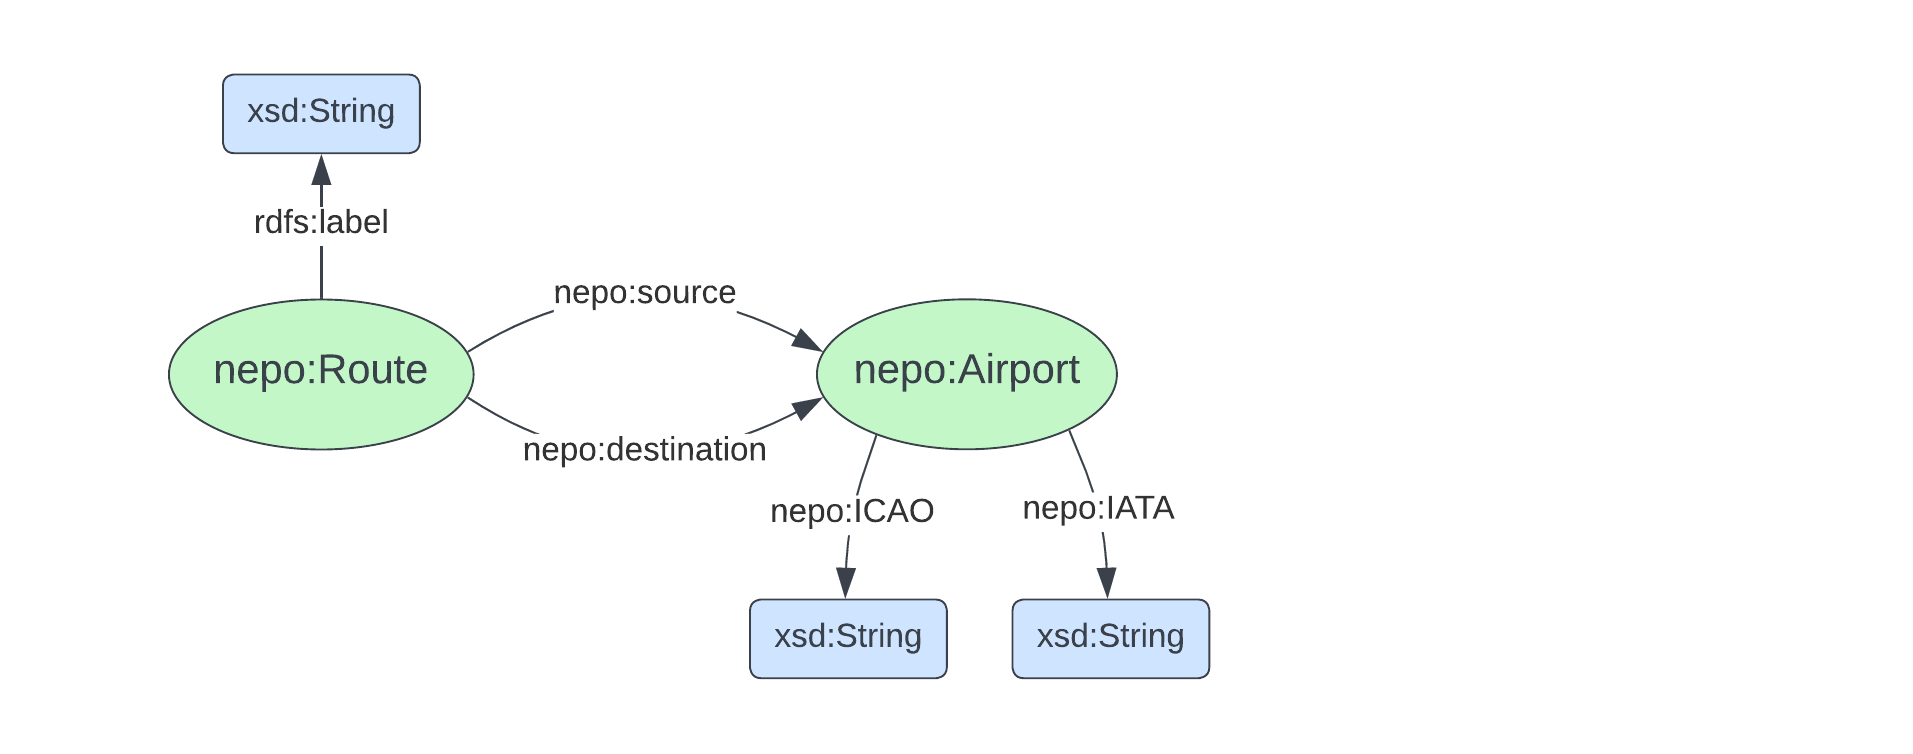

## Creating the Graph

Run the following two cells to load the Air Routes RDF graph, using [Neptune batch load](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/batch-load.html).  

In [ ]:
import graph_notebook as gn

config = gn.configuration.get_config.get_config()
region = config.aws_region

In [ ]:
%load -s s3://aws-neptune-customer-samples-{region}/airroutes-rdf/airroutes.nt -r {region} -f ntriples --run

## Retrieving Instances Count by Class / Node Label 

RDF classes become node labels in openCypher. Here, we execute a query to show how many instances of each RDF class / node label exist in the graph.

#### SPARQL equivalent

```
select ?type (count(?s) as ?count) where {
    ?s a ?type .
} 
group by ?type

```

In [ ]:
%%oc

MATCH (n)
WITH labels(n) AS lbls
UNWIND lbls AS lbl
RETURN lbl AS Label, COUNT(*) AS Count
ORDER BY Count DESC;

### Listing all RDF Object Properties / LPG Edge Labels

RDF object properties are used to relate two resources (i.e., instances of classes) together. For example, `:hasDirectRouteTo` : 

```:JFK :hasDirectRouteTo :LondonHeathrow```

RDF object properties become edge labels in openCypher.

Execute the next cell to see a list of all the RDF object properties / edge labels in the graph.

#### SPARQL equivalent:

```
SELECT DISTINCT ?p WHERE {
    ?s ?p ?o .
    FILTER (isIRI(?o))
} GROUP BY ?p
```

In [ ]:
%%oc
MATCH ()-[r]-()
RETURN DISTINCT type(r) AS relType

### Listing all RDF literal properties / LPG node properties

RDF literal properties link a resource to a literal value, such as a string, number, or date.
For example, `:hasName` : 

```:JFK :hasName "John F. Kennedy International Airport"```

RDF literal properties become node properties in openCypher.

Execute the next cell to see a list of all the RDF literal properties / LPG node properties in the graph.

#### SPARQL equivalent:

```
SELECT DISTINCT ?p WHERE {
    ?s ?p ?o .
    FILTER (isLITERAL(?o))
} GROUP BY ?p
```

In [ ]:
%%oc

MATCH (n)
WITH DISTINCT keys(n) AS nodeKeys
UNWIND nodeKeys AS key
RETURN DISTINCT key;

### Namespace Prefixes

In SPARQL querying, namespace prefixes are often used to make queries easier to read and write. With namespace prefixes, you can define a prefix for part of the fully qualified IRI and use the prefix in its place. 

We have extended the syntax for openCypher to enable this feature when writing openCypher over RDF. 

Prefixes can be defined by adding them to the beginning of the query:

```
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX nepr: <http://neptune.aws.com/ontology/airroutes/resource#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
```
And then they can be used with a double colon:

```
RETURN airport.rdfs::label, airport.nepo::IATA
```
### Querying using full IRIs

Queries can be designed using fully qualified IRIs...

In [ ]:
%%oc

MATCH (airport: `<http://neptune.aws.com/ontology/airroutes/Airport>`)
WHERE airport.`<http://neptune.aws.com/ontology/airroutes/ICAO>` = "KMHT"
RETURN airport.`<http://www.w3.org/2000/01/rdf-schema#label>`,
       airport.`<http://neptune.aws.com/ontology/airroutes/IATA>`

### Querying using Namespace Prefixes

As an alternative, queries can be designed using namespace prefixes:

#### Finding an Airport by its property, the IATA code:

In [ ]:
%%oc

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH (airport: nepo::Airport)
WHERE airport.nepo::IATA = "MHT"
RETURN airport.rdfs::label

#### Finding an Airport node by its ID (RDF Resource IRI):

In [ ]:
%%oc
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX nepr: <http://neptune.aws.com/ontology/airroutes/resource#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH (airport: nepo::Airport)

WHERE id(airport) = nepr::AIRPORT_507    

RETURN airport.rdfs::label

### Finding Direct Flights

Here is an openCypher query that returns all the paths in the graph of direct flights between airports. The query is limited to avoid a large response set.

Select the 'graph' tab in the response to see a network diagram of the paths.
Returning paths in this manner ensures the diagram can be easily rendered as a network.

In [ ]:
%%oc -d <http://www.w3.org/2000/01/rdf-schema#label> 

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH directFlights = (
    (origin: nepo::Airport)
        <-[:nepo::source]-(r: nepo::Route)-[:nepo::destination]->
    (destination: nepo::Airport)
)
RETURN directFlights
LIMIT 30

### Finding 3 Hop Flights

The direct path query is not sufficient to show journeys where multiple stops exist between the source and destination airports. 

The journey between Manchester-Boston and Helsinki has a minimum of three connecting flights. In total, there are 118 possible routes you could take to make the journey. Here we show the RDFS labels of the Route nodes in the graph:

In [ ]:
%%oc
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>

MATCH (origin:nepo::Airport {nepo::IATA: 'MHT'}) 
MATCH (destination:nepo::Airport {nepo::IATA: 'HEL'})

MATCH p=(origin:nepo::Airport)
        -[:nepo::source]-(r)-[:nepo::destination]->()
        -[:nepo::source]-(r2)-[:nepo::destination]->()
        -[:nepo::source]-(r3)-[:nepo::destination]->
        (destination:nepo::Airport)
        
RETURN r.rdfs::label, r2.rdfs::label, r3.rdfs::label

### Adding New Edges with Properties

With RDF1.1, you cannot add properties to edges(predicates). However, because the graph is now in our 1Graph model (interoperable between openCypher and RDF), we can add a new edge, and set a property for the number of stops on the journey. 

Here, we find all the routes with two connecting flights, then for each, we add a new direct edge and a property representing the number of stops:

In [ ]:
%%oc
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>

MATCH p=(origin:nepo::Airport)
        -[:nepo::source]-(r)-[:nepo::destination]->()
        -[:nepo::source]-(r2)-[:nepo::destination]->
        (destination:nepo::Airport)
          
CREATE (origin)-[:nepo::hasMultiStopRouteTo {nepo::stops: 2}]->(destination)                                 

### How many stops are there on a journey between Edinburgh and Helsinki?

With the query below, we can see that a journey between Edinburgh and Helsinki takes two stops.

In [ ]:
%%oc
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>

MATCH (origin:nepo::Airport {nepo::IATA: 'EDI'}) 
MATCH (destination:nepo::Airport {nepo::IATA: 'HEL'})

MATCH (origin)-[r:nepo::hasMultiStopRouteTo]->(destination)

RETURN DISTINCT r.nepo::stops

### Using Pathfinding

While we could extend this feature to record the number of stops for all multi-stop journeys, a more intelligent modification can be made to the graph, making it easier to compute the number of stops on any journey.

Execute the following query to extend the model. This will add an edge directly connecting airports if such a direct route is available.

In [ ]:
%%oc

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH (origin: nepo::Airport)
        <-[:nepo::source]-(r: nepo::Route)-[:nepo::destination]->
      (destination: nepo::Airport)

CREATE (origin)-[:nepo::hasDirectRouteTo]->(destination)

### The extended Ontology / Schema

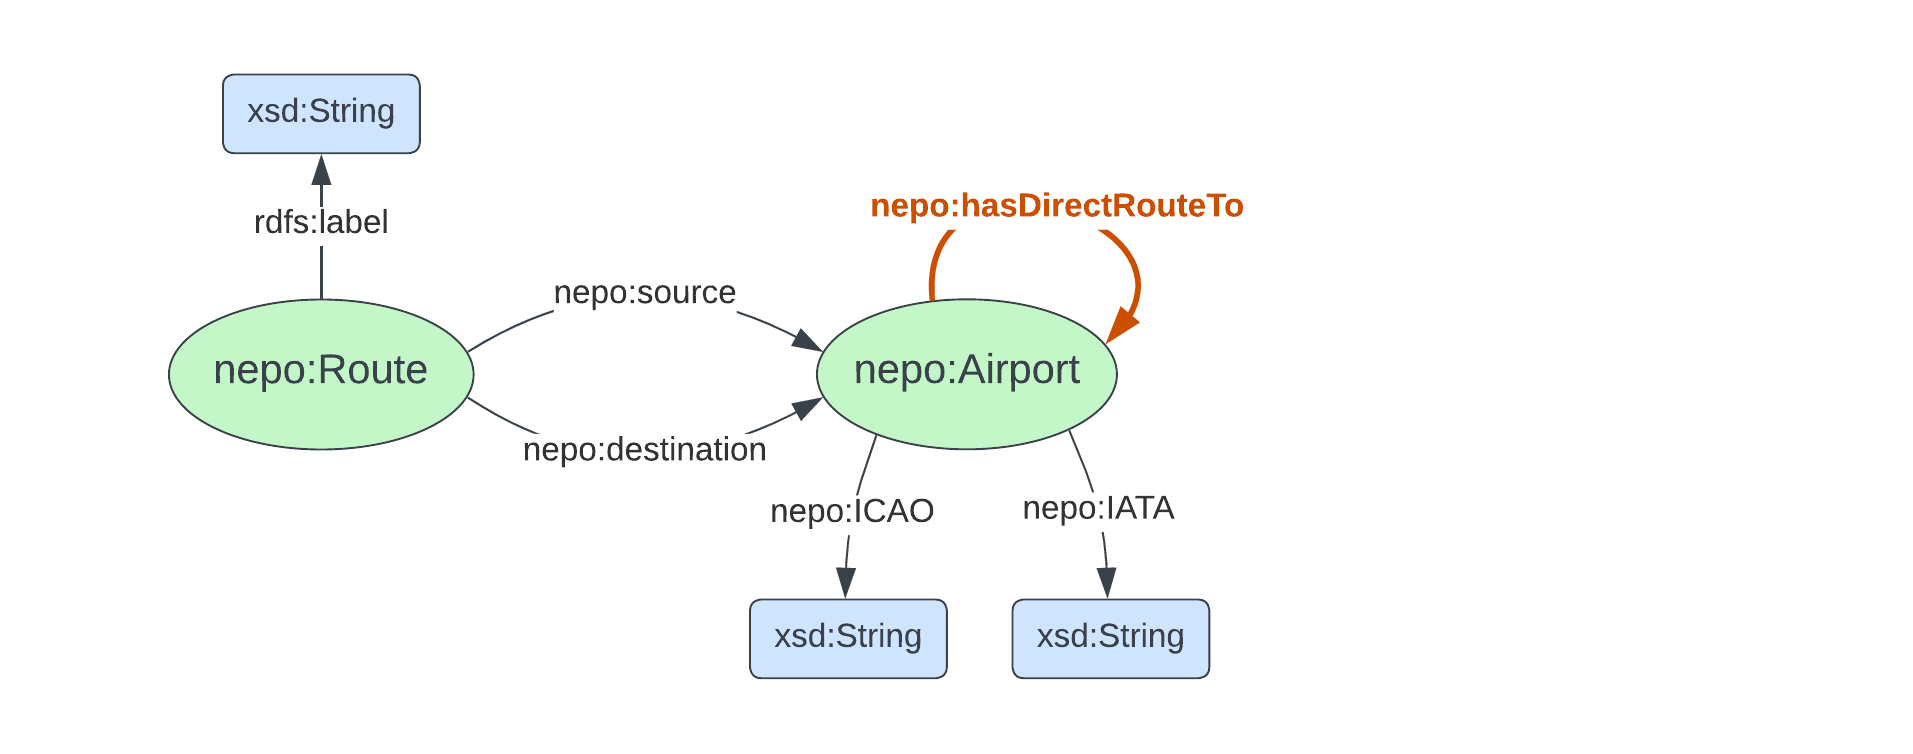

### Variable Length Paths
Now, we can execute openCypher pathfinding queries with variable length paths. 
Execute the query below to see different journeys you can take starting from Manchester-Boston, with up to three stops. Click on the graph tab to see the network diagram.

In [ ]:
%%oc -d <http://www.w3.org/2000/01/rdf-schema#label> 

PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

MATCH (origin:nepo::Airport {nepo::IATA: 'MHT'}) 

MATCH directFlights = (origin)-[r: nepo::hasDirectRouteTo*..3]->(n2)
return directFlights
limit 100

### Neptune Analytics Algorithms

Neptune Analytics provides a set of optimized in-database implementations of common graph algorithms, which are exposed as openCypher procedures. These algorithms analyze inherent aspects of the underlying graph structure, such as connectedness (path finding), relative importance (centrality), and community membership (community detection).

For more information about how to run each of the different algorithms, visit the [Neptune Analytics Algorithms documentation](https://docs.aws.amazon.com/neptune-analytics/latest/userguide/algorithms.html).

Here, we run the PageRank algorithm to see which airports are the busiest.

In [ ]:
%%oc
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX nepo: <http://neptune.aws.com/ontology/airroutes/>

MATCH (airport:nepo::Airport)

CALL neptune.algo.pageRank(airport, {
   edgeLabels : [nepo::hasDirectRouteTo] 
})
YIELD node
MATCH (node)-[e: nepo::hasDirectRouteTo]-()

RETURN id(airport), airport.rdfs::label, COUNT(e) AS connections, airport.nepo::ICAO
ORDER BY connections DESC
LIMIT 100